# Precipitable Water Delta Analysis with MERRA-2 S3 Bucket Data
### Author: Chris Battisto


## Project Description and Goals

- Read in hourly M2T1NXSLV via the GES-DISC S3 bucket
- Subset CONUS, take 3-year May averages between 1980-83 and 2010-2013, perform delta analysis on total precipitable water

## Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import requests
import numpy as np
import xarray as xr
import s3fs
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import dask
import geopandas as gpd

## Access M2T1NXSLV via S3 Bucket

First, create the netrc file that contains your EarthData login information required to access the S3 token.
Note that this only needs to be ran once and stored in the parent directory.

In [1]:
''' Modified from Tutorial 4 '''

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Set as .netrc since we are in an EC2 instance
netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    
# Skips to end since .netrc has already been created for me

### Get S3 token

This token expires after one hour, and this block will need to be re-ran if time expires.

In [2]:
''' Modified from Hackathon Tutorials '''

gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials

def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

# Check that the file system is intact, means that token is valid
type(fs)

s3fs.core.S3FileSystem

### Glob list of S3 files from the two time periods

In [3]:
# Files are organized by s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/year/mo/*

# Period 1 (May 1980-84), Period 2 (May 2000-2004)
p1_files, p2_files = [], [] 

for yr in range(1980, 1984):
    p1_files.extend(fs.glob("s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/"+str(yr)+"/05/*"))

for yr in range(2000, 2004):
    p2_files.extend(fs.glob("s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/"+str(yr)+"/05/*"))
    
len(p1_files)

124

### Use Dask parallel processing to subset the two periods

In [4]:
%%time

p1_ds = xr.open_mfdataset(
    paths=[fs.open(f) for f in p1_files],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
)

p2_ds = xr.open_mfdataset(
    paths=[fs.open(f) for f in p2_files],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
)


CPU times: user 2min 59s, sys: 24.7 s, total: 3min 24s
Wall time: 8min 34s


In [5]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

# ONLY select TQL (total precipitable water) and resample yearly (check if in UTC)
ds_arr = [p1_ds.TQL.resample(time='1M').mean(), p2_ds.TQL.resample(time='1M').mean()]

# Compute in parallel, show progress
ds_arr_compute = dask.compute(ds_arr)
ds_arr_compute

[########################################] | 100% Completed | 19min 37.4s


([<xarray.DataArray 'TQL' (time: 37, lat: 361, lon: 576)>
  array([[[0.00091232, 0.00091232, 0.00091232, ..., 0.00091232,
           0.00091232, 0.00091232],
          [0.00126882, 0.00127189, 0.00127488, ..., 0.00125965,
           0.00126273, 0.00126577],
          [0.00140709, 0.00140894, 0.0014109 , ..., 0.0014017 ,
           0.00140345, 0.00140524],
          ...,
          [0.03103162, 0.03102872, 0.03102605, ..., 0.03104326,
           0.03103884, 0.03103501],
          [0.03487696, 0.0348887 , 0.03490096, ..., 0.03484557,
           0.03485522, 0.03486607],
          [0.03847232, 0.03847232, 0.03847232, ..., 0.03847232,
           0.03847232, 0.03847232]],
  
         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
  ...
          [      

### Create deltas and plot only over CONUS

In [6]:
# Select the CONUS range

lats=slice(20,55)
lons=slice(-130, -50)

# Subset, remember that computed arrays are stored in a parent array

p1_da = ds_arr_compute[0][0].sel(lat=lats, lon=lons)
p2_da = ds_arr_compute[0][1].sel(lat=lats, lon=lons)

# Coarsen if desired
# p1_da = da_1.coarsen(lon=x).mean().coarsen(lat=y).mean()
# p2_da = da_2.coarsen(lon=x).mean().coarsen(lat=y).mean()

tql_deltas = p2_da.values - p1_da.values

# Put into its own Xarray dataset
tql_deltas_ds = xr.Dataset({'TQL_DELTAS': (('time', 'lat', 'lon'), tql_deltas)},
                coords={'time': (('time'), p1_da.time.values),
                        'lat': (('lat'), p1_da.lat.values),
                        'lon': (('lon'), p1_da.lon.values)})

tql_deltas_ds

<xarray.Dataset>
Dimensions:     (time: 37, lat: 71, lon: 129)
Coordinates:
  * time        (time) datetime64[ns] 1980-05-31 1980-06-30 ... 1983-05-31
  * lat         (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 53.5 54.0 54.5 55.0
  * lon         (lon) float64 -130.0 -129.4 -128.8 ... -51.25 -50.62 -50.0
Data variables:
    TQL_DELTAS  (time, lat, lon) float32 -0.009996 -0.008841 ... -0.004934

### Plot deltas

Text(0.5, 1.0, 'Average May TQL Deltas, May 2000, 1980')

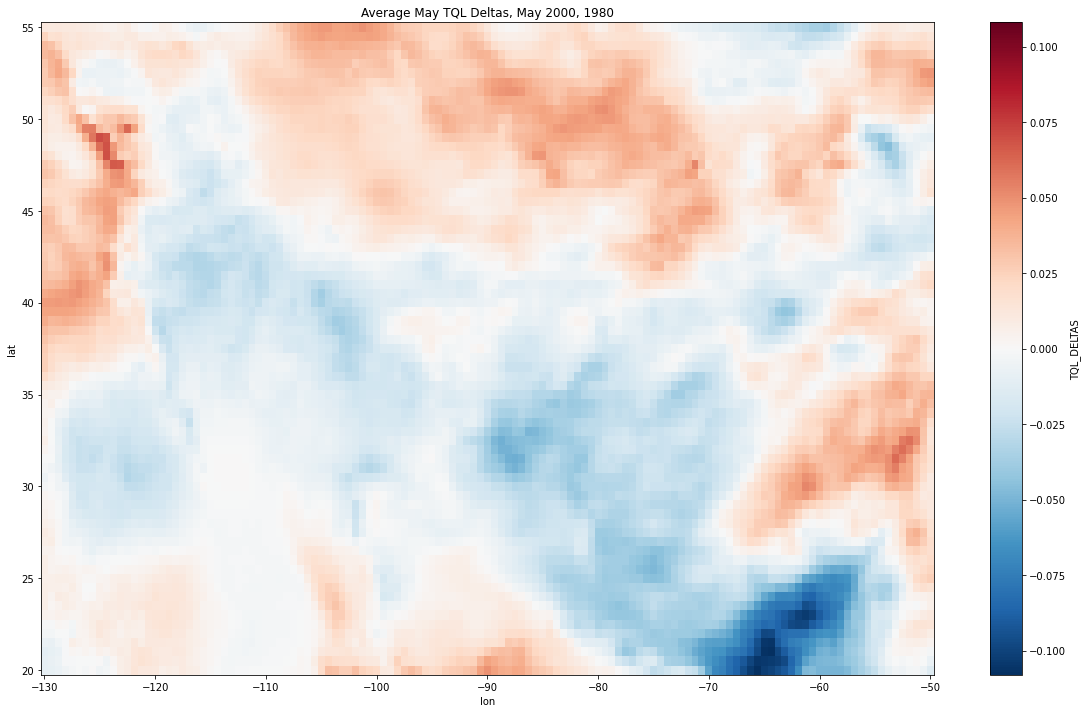

In [7]:
fig,ax = plt.subplots(figsize = (20,12))

tql_deltas_ds.TQL_DELTAS[0,:,:].plot()

ax.set_title("Average May TQL Deltas, May 2000, 1980")